<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/09_SkimLit_NLP_Projectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

NLP model to make medical abstracts reading easier

https://arxiv.org/abs/1710.06071 [NN for joint sentence classification]

https://arxiv.org/abs/1612.05251 [PubMed 200k RCT]

In [1]:
!nvidia-smi

Wed Sep 21 12:59:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Download the dataset used in Pubmed https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data


In [5]:
# Create func to read the lines of a document

def getlines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [6]:
# Reading Training lines
train_lines = getlines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
  input_lines = getlines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract 
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  return abstract_samples

In [8]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [9]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head(12)

,target,text,line number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribuition of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

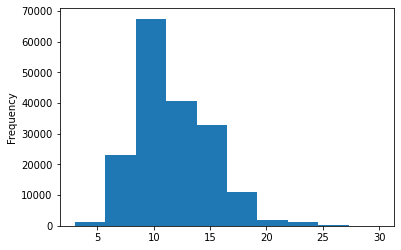

In [13]:
# Lets checek thel enght of different lines

train_df.total_lines.plot.hist()

### Get list of sentences



In [14]:
# Convert abstract text lines into lists

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [15]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)



In [16]:
# One hot encoding labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


In [17]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
### Encoding labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [19]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Series of modelling experiments



### Model 0 : Getting a baseline 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model

model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-21 12:59:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-21 12:59:51 (63.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
 # Cal baesline results

 baseline_results = calculate_results(y_true = val_labels_encoded,
                                      y_pred = baseline_preds )

In [26]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for our deep squence models

Before we start we got to create vectoriztion and embedding layers

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <a list of 25 Patch objects>)

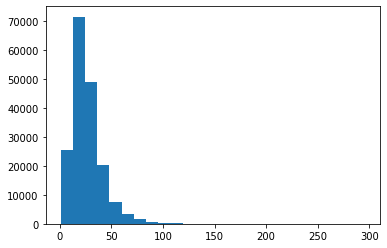

In [29]:
# What does the distribution look lik

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 25)

In [30]:
# How long of a sentence lenght convers 95% of examples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer layer

In [31]:
# How many words are in our vocab
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer  = TextVectorization(max_tokens = max_tokens,
                                     output_sequence_length= output_seq_len)

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences

import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text\n: {len(target_sentence)}')
print(f'\nVectorizes test\n:{text_vectorizer([target_sentence])}')

Text:
 the purpose of this study was to investigate the impact of an internet-based glaucoma care support system on glaucoma medication use .

Length of text
: 134

Vectorizes test
:[[   2  695    4   23   17   10    6  331    2  305    4   26 3096 1803
    77  279  355   18 1803  320   87    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# How mnay owrds in our training vocab

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding




In [37]:
# Create tokem embeddging layer

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128, 
                               mask_zero = True, # Hanndle variable seq length
                               name = 'token_embedding')       

In [38]:
# Show example embedding
print(f'Before Vectoriztion:\n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'After Vectorization:\n {vectorized_sentence}\n')
embeded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embeded_sentence}\n')
print(f'Embedded sentence shape:\n {embeded_sentence.shape}')

Before Vectoriztion:
the purpose of this study was to investigate the impact of an internet-based glaucoma care support system on glaucoma medication use .

After Vectorization:
 [[   2  695    4   23   17   10    6  331    2  305    4   26 3096 1803
    77  279  355   18 1803  320   87    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01888957  0.02434191 -0.04027537 ...  0.0253467   0.00471332
    0.02863142]
  [-0.02513634 -0.03576131 -0.01195671 ... -0.03037202  0.00132673
    0.02370806]
  [ 0.03278441  0.01445976  0.03197687 ...  0.0082993   0.04933599
    0.02941246]
  ...
  [ 0.000234    0.0198151   0.03161314 ... -0.03850731  0.0251073
   -0.02549914]
  [ 0.000234    0.0198151   0.03161314 ... -0.03850731  0.0251073
   -0.02549914]
  [ 0.000234    0.0198151   0.03161314 ... -0.03850731  0.0251073
   -0.02549914]]]

Embe

## Creating datasets(making sure our data loads as fast as possible)



In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [40]:
# Turn dataets into prefetched
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

 ## Model 1: Conv1D with token embeddings
 

In [41]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [42]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x  = layers.Conv1D(64,kernel_size = 5, padding = 'same', activation = 'relu' )(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [43]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [44]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 10ms/step - loss: 0.9177 - accuracy: 0.6377 - val_loss: 0.6843 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6607 - accuracy: 0.7528 - val_loss: 0.6326 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6221 - accuracy: 0.7705 - val_loss: 0.5993 - val_accuracy: 0.7819


In [45]:
# Eval on whole valid dataest
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6028 - accuracy: 0.7834


[0.6028250455856323, 0.7834303975105286]

In [46]:
model_1_pred_probs = model_1.predict(valid_dataset)

In [47]:
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1891024e-01, 1.6992591e-01, 8.2691073e-02, 3.0225053e-01,
         2.6222283e-02],
        [4.9971488e-01, 2.4143273e-01, 1.3778950e-02, 2.3814681e-01,
         6.9266213e-03],
        [1.6517732e-01, 8.1018293e-03, 1.8976117e-03, 8.2477683e-01,
         4.6419227e-05],
        ...,
        [2.4684355e-06, 5.6778814e-04, 5.0656812e-04, 2.8743052e-06,
         9.9892032e-01],
        [5.8911264e-02, 3.9771333e-01, 1.3206856e-01, 7.7034816e-02,
         3.3427209e-01],
        [1.5271479e-01, 6.8623632e-01, 3.8201470e-02, 3.7062522e-02,
         8.5784860e-02]], dtype=float32), (30212, 5))

In [48]:
# Convert pred probs to classes 

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

In [50]:
model_1_results

{'accuracy': 78.343042499669,
 'precision': 0.7795109374317012,
 'recall': 0.78343042499669,
 'f1': 0.7806913557191875}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_2 Feature Extraction model

Now lets use pretrained word embedding in tensorflow hub

The paper originally used Glove embedding but we are using Universal Sentence Encoder

In [52]:
# Download USE

import tensorflow_hub as hub

hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 trainable = False,
                                 name = 'Universal_Sentence_Encoder')

In [53]:
# Test USE

random_train_sentence = random.choice(train_sentences)
print('Random sent:\n')
print(random_train_sentence)

use_embedded_sentence = hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n')
print(use_embedded_sentence)

Random sent:

in cohort @ , we randomly assigned @ patients to the @-week regimen ( @ with ribavirin and @ with no ribavirin ) and @ to the @-week regimen ( @ with ribavirin and @ with no ribavirin ) ; in cohort @ , we randomly assigned @ patients to the @-week regimen ( @ with ribavirin and @ with no ribavirin ) and @ to the @-week regimen ( @ with ribavirin and @ with no ribavirin .
Sentence after embedding:

tf.Tensor(
[[-0.07050951 -0.06027018 -0.02114944 -0.00847946  0.00669744  0.07411705
   0.06924518 -0.06585914  0.06860248  0.05567664  0.07311385 -0.00013659
  -0.01419298  0.03754657 -0.01926301  0.01348038 -0.07890414 -0.02893151
  -0.03774301 -0.0195376   0.07543577  0.04844598 -0.05659095 -0.01872188
   0.07096916  0.00827104 -0.03068808  0.02027711  0.02662974  0.04078866
   0.05122031  0.07902752  0.0147323  -0.00485008 -0.03978748  0.0265199
   0.00751838 -0.04512708  0.00813202 -0.06589155  0.01150801  0.07497486
  -0.0119742  -0.05512105  0.03794696  0.0646252  -0.0427

In [54]:
len(use_embedded_sentence[0])

512

In [55]:
# Create Model_2 (feature extraction model)

inputs = layers.Input(shape=[], dtype = tf.string)
embedding = hub_embedding_layer(inputs)
# x = layers.Conv1D(64,kernel_size = 4, padding = 'same', activation = 'relu')(embedding)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation = 'relu')(embedding)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

In [56]:
# COmpile model 2
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [57]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
# Fit the model

history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9174 - accuracy: 0.6492 - val_loss: 0.7949 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7677 - accuracy: 0.7031 - val_loss: 0.7525 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7511 - accuracy: 0.7120 - val_loss: 0.7368 - val_accuracy: 0.7134


In [59]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7402 - accuracy: 0.7140


[0.7401765584945679, 0.7140209078788757]

In [60]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4091871e-01, 3.3558598e-01, 2.3763254e-03, 2.1260275e-01,
        8.5162027e-03],
       [3.6836371e-01, 4.8678917e-01, 3.8062914e-03, 1.3841525e-01,
        2.6256209e-03],
       [2.2500773e-01, 1.4574344e-01, 1.9434394e-02, 5.7351071e-01,
        3.6303796e-02],
       ...,
       [1.6333460e-03, 7.2456202e-03, 5.2149765e-02, 7.6856965e-04,
        9.3820268e-01],
       [3.8207034e-03, 5.5835314e-02, 1.8654847e-01, 1.3122257e-03,
        7.5248325e-01],
       [1.6781449e-01, 2.7652770e-01, 4.9915826e-01, 8.6056441e-03,
        4.7893994e-02]], dtype=float32)

In [61]:
# Convert the prediction probs tolabels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [62]:
# Calculate results from pretrained embedding 
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.4020918840196,
 'precision': 0.7142225899387462,
 'recall': 0.7140209188401959,
 'f1': 0.7111613809290264}

## Model3 : Conv1D with character level tokenization

The paper we are replicating used char lvl embedding and world lvl embedding

### Creating a char level tokenizer



In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
def split_chars(text):
  return ' '.join(list(text))

In [66]:
# Split sequence level data splits into char level data spilts

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for  sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [68]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

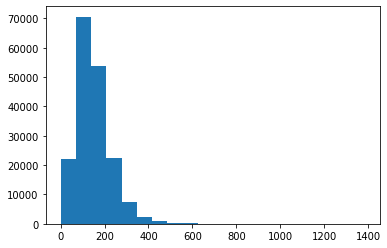

In [71]:
# Check the distribution of the sequences at a char level

import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 20)

In [73]:
# Find what char lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [103]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [104]:
# Create char lvl token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2 # '+2' for space and OOV
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize = None,
                                    name = 'char_vectorizer')

In [105]:
# Adapt char vectorizer to training character

char_vectorizer.adapt(train_chars)

In [106]:
# Check char vocab stats 
char_vocab = char_vectorizer.get_vocabulary()
print(f'Num of diff char {len(char_vocab)}')
print(f'5 most common char: {char_vocab[:5]}')
print(f'% least common char: {char_vocab[-5:]}')

Num of diff char 28
5 most common char: ['', '[UNK]', 'e', 't', 'i']
% least common char: ['k', 'x', 'z', 'q', 'j']


In [110]:
# Test  out our char vectorizer

random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Len of random_train_char:{len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n {vectorized_chars}')
print(f'Len of vectorized chars:{len(vectorized_chars[0])}')

Charified text:
 p r o p o f o l   w a s   i n j e c t e d   @   m i n   l a t e r   .
Len of random_train_char:29
Vectorized chars:
 [[14  8  7 14  7 17  7 12 20  5  9  4  6 27  2 11  3  2 10 15  4  6 12  5
   3  2  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0